In [1]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as opt
from tqdm.notebook import tqdm
%matplotlib inline

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('running on gpu...')
else:
  device = torch.device('cpu')
  print('running on cpu...')

running on cpu...


In [2]:
BATCHSIZE = 128
LR = 0.002
ZDIM = 100
IMG_SIZE = (28,28)
EPOCHS = 20
BETA1 = 0.5

In [3]:
#utility functions
def imview(imgs):
    dev = torch.device('cpu')
    imgs = imgs.to(dev)
    imgs = tv.utils.make_grid(imgs)
    imgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(imgs,(1,2,0)))
    plt.show()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
class RangeNormalize(object):
    """
      Credits: https://github.com/ncullen93
    """
    def __init__(self, 
                 min_val, 
                 max_val):
        """
        Normalize a tensor between a min and max value
        Arguments
        ---------
        min_val : float
            lower bound of normalized tensor
        max_val : float
            upper bound of normalized tensor
        """
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, *inputs):
        outputs = []
        for idx, _input in enumerate(inputs):
            _min_val = _input.min()
            _max_val = _input.max()
            a = (self.max_val - self.min_val) / (_max_val - _min_val)
            b = self.max_val- a * _max_val
            _input = _input.mul(a).add(b)
            outputs.append(_input)
        return outputs if idx > 1 else outputs[0]

In [4]:
transforms = tv.transforms.Compose([tv.transforms.ToTensor(),RangeNormalize(-1,1)])
traindata = tv.datasets.MNIST('data',train=True,transform=transforms,download=False)
trainloader = torch.utils.data.DataLoader(traindata,batch_size=BATCHSIZE,shuffle=True,num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


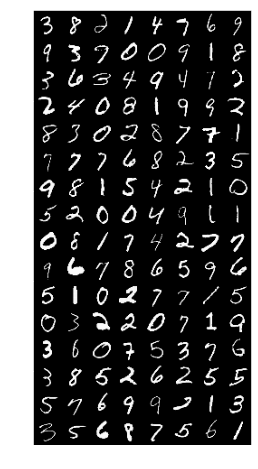

In [5]:
train = iter(trainloader)
x = train.next()
imview(x[0])

In [6]:
class Gen(nn.Module):
    def __init__(self,ZDIM):
        super(Gen,self).__init__()

        self.lin1 = nn.Linear(ZDIM,256*7*7)

        self.convT1 = nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.convT2 = nn.ConvTranspose2d(128,64,kernel_size=3,stride=1,padding=1)
        self.convT3 = nn.ConvTranspose2d(64,1,kernel_size=3,stride=2,padding=1,output_padding=1)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(1)

    def forward(self,x):
        x = self.lin1(x)
        x = F.leaky_relu(self.bn1(self.convT1(x.view(-1,256,7,7))), negative_slope = 0.01)
        x = F.leaky_relu(self.bn2(self.convT2(x)), negative_slope = 0.01)
        x = F.tanh(self.bn3(self.convT3(x)))
        return x


In [7]:
class Dis(nn.Module):
    def __init__(self,IMG_SIZE):
        super(Dis,self).__init__()

        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,stride=2,padding=0)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.flat = nn.Flatten()

        self.lin = nn.Linear(128*3*3,1)

    def forward(self,x):
        x = x.view(-1,1,28,28)
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope = 0.01)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope = 0.01)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope = 0.01)
        x = F.sigmoid(self.lin(self.flat(x)))
        return x



In [8]:
# Instantiating the networks
G = Gen(ZDIM).apply(weights_init).to(device)
D = Dis(IMG_SIZE).apply(weights_init).to(device)

In [9]:
# Defining solver to do the mini batch stochastic gradient descent 
# one for each network 
G_solver = opt.Adam(G.parameters(), lr = LR,betas=(BETA1, 0.999))
D_solver = opt.Adam(D.parameters(), lr = LR,betas=(BETA1, 0.999))

Running epoch 0...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:0,   G_loss:2.048890241348286,   D_loss:0.8560702659761601


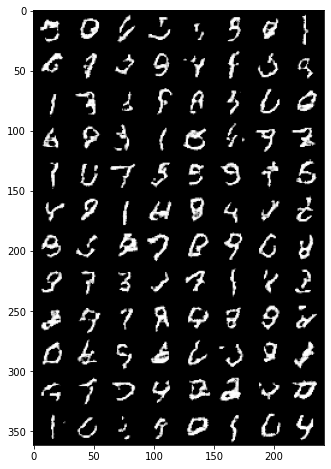

Running epoch 1...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:1,   G_loss:1.9606134522634784,   D_loss:0.7349929223055525


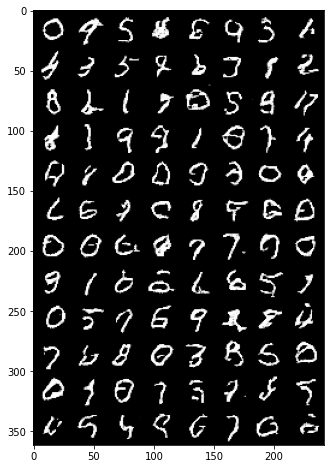

Running epoch 2...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:2,   G_loss:2.208285106683591,   D_loss:0.6148408618944285


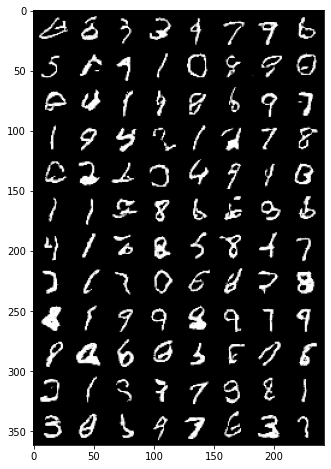

Running epoch 3...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:3,   G_loss:2.451881124584405,   D_loss:0.5530307605258946


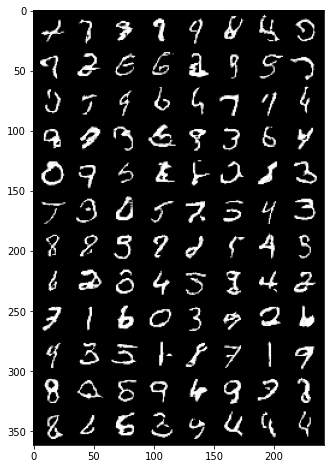

Running epoch 4...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:4,   G_loss:2.6633504183053462,   D_loss:0.4921810741045836


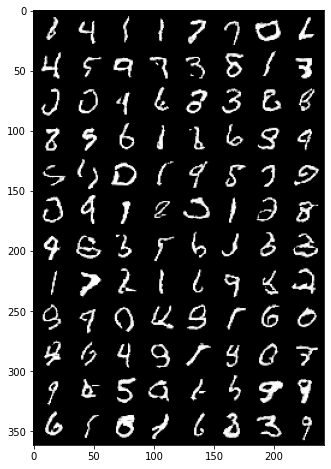

Running epoch 5...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:5,   G_loss:2.7626064564627626,   D_loss:0.4856320153167253


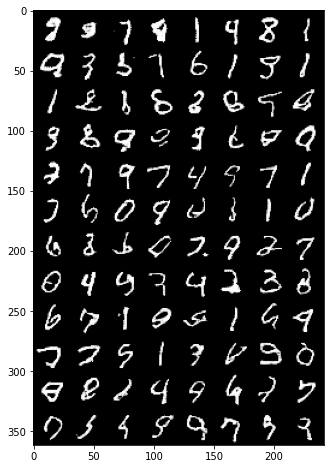

Running epoch 6...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:6,   G_loss:2.9255370996844796,   D_loss:0.428698739803422


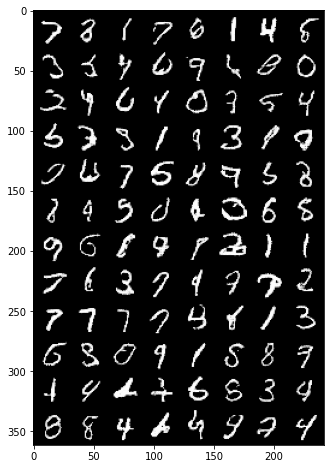

Running epoch 7...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:7,   G_loss:3.1887379584214424,   D_loss:0.38789513508584705


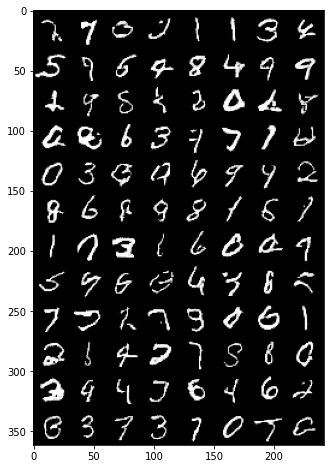

Running epoch 8...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:8,   G_loss:3.342440351526112,   D_loss:0.3592850699194713


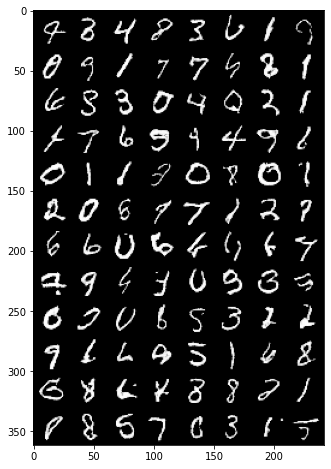

Running epoch 9...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:9,   G_loss:3.3657017843301364,   D_loss:0.3744231740326515


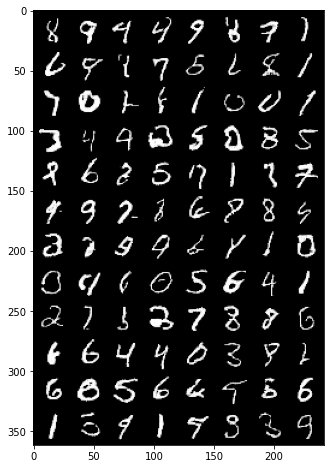

Running epoch 10...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:10,   G_loss:3.5969713738700473,   D_loss:0.3210466852240852


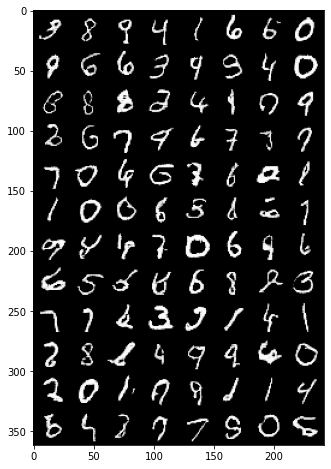

Running epoch 11...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:11,   G_loss:3.9298413042574802,   D_loss:0.21977074592829005


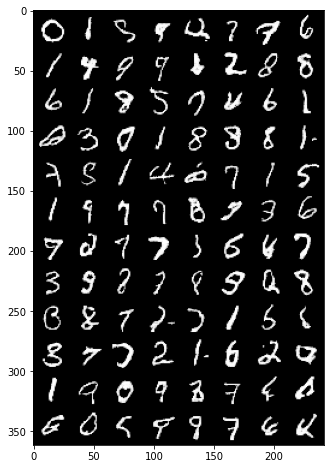

Running epoch 12...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:12,   G_loss:3.953637547414702,   D_loss:0.304178327449095


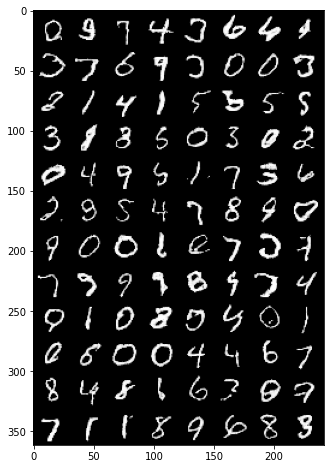

Running epoch 13...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:13,   G_loss:4.052754117036933,   D_loss:0.21870069339998496


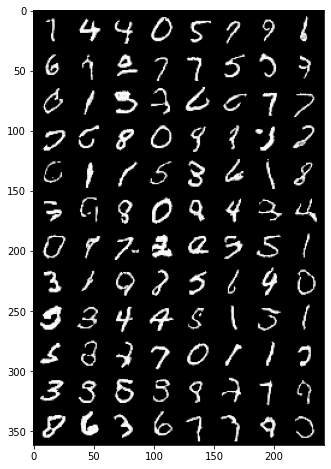

Running epoch 14...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:14,   G_loss:4.3280278927227585,   D_loss:0.2060355363703613


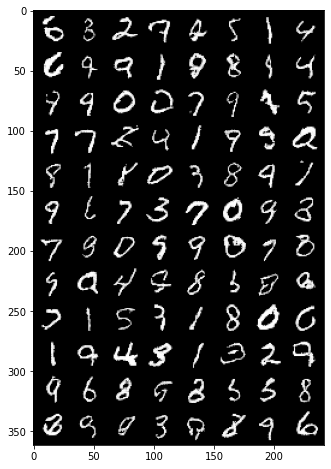

Running epoch 15...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:15,   G_loss:4.433680234814504,   D_loss:0.24153027266486368


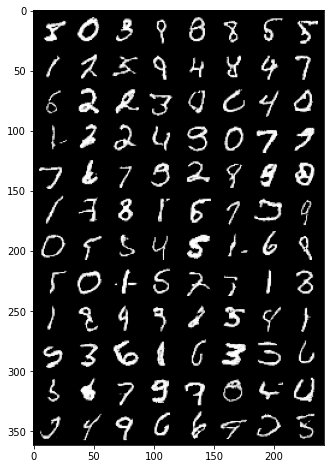

Running epoch 16...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:16,   G_loss:4.2932165789324594,   D_loss:0.27239932495552593


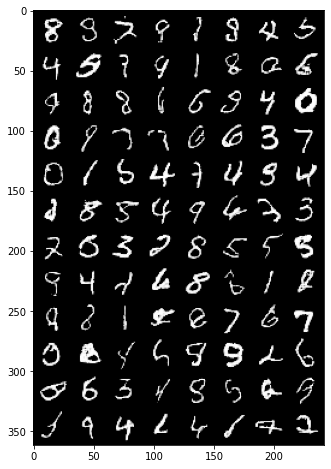

Running epoch 17...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:17,   G_loss:4.569575178343604,   D_loss:0.14866806686456716


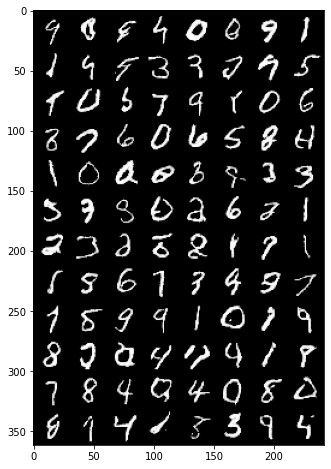

Running epoch 18...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:18,   G_loss:4.370859180076687,   D_loss:0.2809324506868813


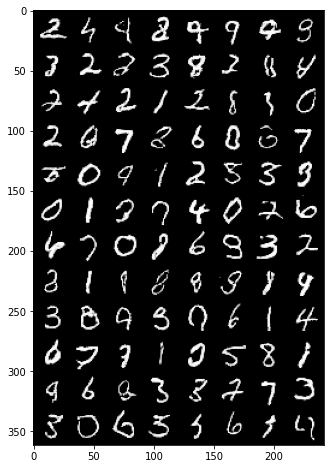

Running epoch 19...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:19,   G_loss:4.615761962272465,   D_loss:0.15794793119244993


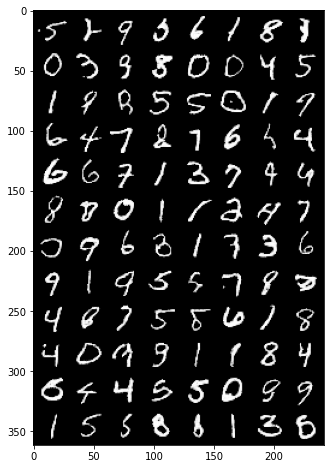

Training time: 8.71890774567922


In [10]:
# Defining the training for loop
import time
start = time.time()
for epoch in range(EPOCHS):
    print("Running epoch {}...".format(epoch))
    G_loss_run = 0.0
    D_loss_run = 0.0
    
    #steps for discriminator at each epoch is set to 3
    for i,data in tqdm(enumerate(trainloader)):
        X, _ = data
        X = X.to(device)
        BATCHSIZE = X.shape[0]

        # Definig labels for real (1s) and fake (0s) images
        one_labels = torch.ones(BATCHSIZE, 1).to(device)
        zero_labels = torch.zeros(BATCHSIZE, 1).to(device)

        # Random normal distribution for each image
        z = torch.randn(BATCHSIZE, ZDIM).to(device)
        # Feed forward in discriminator both 
        # fake and real images
        D_real = D(X)
        # fakes = G(z)
        D_fake = D(G(z))

        # Defining the loss for Discriminator
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_fake_loss + D_real_loss

        # backward propagation for discriminator
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        # Feed forward for generator
        z = torch.randn(BATCHSIZE, ZDIM).to(device)
        D_fake = D(G(z))
        
        # loss function of generator
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        # backward propagation for generator
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    # printing loss after each epoch 
    print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1) ))
    
    # Plotting fake images generated after each epoch by generator
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28)
    imview(samples)
        
print("Training time: {}".format((time.time()-start)/60))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 28, 28])


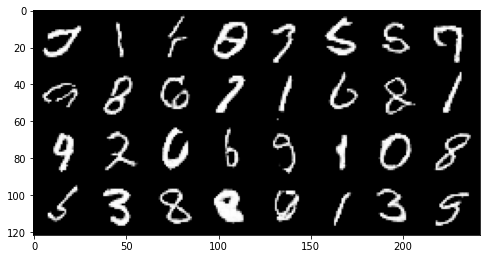

In [11]:
z = torch.randn(32, ZDIM).to(device)
samples = G(z).detach()
print(samples.shape)
samples = samples.view(samples.size(0), 1, 28, 28)
imview(samples)